In [ ]:
%pip install --upgrade pip
%pip install scipy
%pip install numpy
%pip install pandas
%pip install matplotlib

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/DataMining/A1')

Mounted at /content/drive/


### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [3]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

train_data_features = train_data.drop(['Timestamp', 'Normal/Attack'], axis=1)
test_data_features= test_data.drop(['Timestamp', 'Normal/Attack'], axis=1)

In [ ]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101', 'LIT101'])
visualize_sensor_data(train_data, window=(200, 800), sensors=['FIT301'])
visualize_sensor_data(train_data)

## Dynamic Time Wrapping

In [4]:
def dynamic_time_warping(a, b):
    x = len(a)
    y = len(b)
    dtw_distance = np.inf

    dp = np.full((x + 1, y + 1), np.inf)
    
    dp[0][0] = 0


    for i in range(1, x + 1):
        for j in range(1, y + 1):
            distance = (a[i - 1] - b[j - 1])**2
            dp[i][j] = distance + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])


    dtw_distance = np.sqrt(dp[x][y])



    return dtw_distance

## Principal Component Analysis

In [5]:
def principal_component_analysis(df, k):
 
    centered = df - df.mean(axis=0)
    cov = np.cov(centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    descending_sorted = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, descending_sorted]

    top_eigenvectors = eigenvectors[:, :k]

    return top_eigenvectors

In [6]:
def apply_principal_component_analysis(df, eigenvectors):
    centered = df - df.mean(axis=0)
    final_proj = np.dot(centered, eigenvectors)

    return pd.DataFrame(final_proj)

## Familiarization

### What types of signals are there?
When we analyze the training data set that we have, it can be seen that there are broadly 3 different kinds of information: The timestamp of the signal the type of the signal whether the signal represents normal or attack state There are 9 types of signals; however, this is a broad categorization as actually the types have subtypes that we must consider. If all kinds of signals are individually considered, there are 49 types of unique signals. Another approach to types of signals can be whether they are discrete or continuous. Discrete signals can take only certain values within a range while continuous signals can take any values within a range. For instance, the attack status signal is a discrete one while all of the FIT signals are examples of continuous signals.

### Are the signals correlated? Do they show cyclic behavior?
Yes, all of the types of signals show cyclic behavior after a certain milestone and one different sensor values. Besides a couple of exception signals, almost all of the signals have a "warm-up" phase where they reach (with or without a repetitive behaviour) the sensor value that they will eventually keep. Furthermore, by looking at the data it can be concluded that there are signals which are correlated with each other. This is not only by their sensor values, but also by the behavior they show especially after their warm-up phase. We talked about how there are subcategories of the categories for the signals. Those types of signals that are in the same category (Like FIT and M signals) usually show correlated behaviours as their behavior and results seem to have an impact on the other similar type of signals.

## DTW-based anomaly detection

In [111]:
from numpy.lib.stride_tricks import sliding_window_view

def create_sliding_windows_optimized(data, window_size, stride):
    shape = (data.size - window_size + 1, window_size)
    strides = (data.strides[0], data.strides[0])
    windows = np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)[::stride]
    return windows

def subset_data(data, step=10):
    return data[::step]

def compute_dtw_distances(train_signal, test_signal, window_size, stride):
    train_windows = create_sliding_windows_optimized(train_signal, window_size, stride)
    test_windows = create_sliding_windows_optimized(test_signal, window_size, stride)
    
    return np.array([np.min([dynamic_time_warping(w, tw) for tw in train_windows[:train_subspace_size]])
                          for w in test_windows[:test_subspace_size]])



def plot_dtw_distances(dtw_distances):
    plt.figure(figsize=(15, 5))
    plt.plot(dtw_distances)
    plt.title('DTW Distances for Test Windows Against Training Windows')
    plt.xlabel('Test Window Index')
    plt.ylabel('DTW Distance')
    plt.show()
    

train_subspace_size = 100
test_subspace_size = 100

# Train data
signal = train_data['LIT101'].values
normalized_signal = (signal - np.mean(signal)) / np.std(signal)

# Test data
test_data = pd.read_csv('lab1_test.csv', delimiter=',')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_signal = test_data['LIT101'].values
normalized_test_signal = (test_signal - np.mean(test_signal)) / np.std(test_signal)

# Subset for faster evaluation
subsampled_signal = subset_data(normalized_signal, step=10)
subsampled_test_signal = subset_data(normalized_test_signal, step=10)

In [116]:
# Window parameters
window_size = 100
stride = 60

train_windows = create_sliding_windows_optimized(subsampled_signal, window_size, stride)
test_windows = create_sliding_windows_optimized(subsampled_test_signal, window_size, stride)
dtw_distances = np.array([np.min([dtw(w, tw) for tw in train_windows[:train_subspace_size]])
                         for w in test_windows[:test_subspace_size]])

plt.figure(figsize=(15, 5))
plt.plot(dtw_distances)
plt.title('DTW Distances for Test Windows Against Training Windows')
plt.xlabel('Test Window Index')
plt.ylabel('DTW Distance')
plt.show()

KeyboardInterrupt: 

### Reflection
##### What kind of anomalies can be detected with DTW?
With DTW you can detect out of order (timewise) anomalies, it can help to shift the sequence inphase to see possible anomalies
#### Analysis
##### Sliding window: 100; Stride: 100


## PCA-based anomaly detection
Perform PCA-based anomaly detection on the signal multivariate data points (do not
take sequential context into account). You compute PCA to the train data, and apply it to
both the train and test data. Plot the distance (residual, your choice of distance function)
between the original and reconstructed data points. Do you see large abnormalities in
the training data? Can you explain why these occur? It is best to remove such
abnormalities from the training data since you only want to model normal behavior.
Describe the kind of anomalies you expect to detect using PCA.
Plot the PCA residuals for different number of components on the training data as one
signal. Choose the number of components based on the residuals and detected
anomalies. Aim to set it such that you expect a small number of false alarms while still
able to detect anomalies. Show your analysis and explain your expectation.



In [9]:
def pca_anomalies_detection(train_data_features, test_data_features, num_components):
    # Use train data to generate top eigenvectors
    top_eigenvectors = principal_component_analysis(train_data_features, num_components)

    # Find the mean of test data
    test_data_mean = np.mean(test_data_features.values, axis=0) # Dataframe
    
    # Project the test data using eigenvectors from train data
    test_projected_data = apply_principal_component_analysis(test_data_features, top_eigenvectors)
    
    # Reconstruct the data
    test_reconstructed_data = test_projected_data.dot(top_eigenvectors.T)
    test_reconstructed_data = test_reconstructed_data.values + test_data_mean
    
    # Calcuting residuals
    return np.linalg.norm((test_data_features) - test_reconstructed_data, axis=1) 

### Graphing PCA Residuals

In [12]:
def plot_residuals(residuals, multiplier = None):
    if multiplier is None:
        multiplier = 0
        
    mean = np.mean(residuals)
    std = np.std(residuals)
    
    plt.plot(residuals, label='PCA Residuals')
    plt.axhline(y=mean + multiplier * std, color='r', linestyle='--', label='Upper Bound')
    plt.axhline(y=mean - multiplier * std, color='g', linestyle='--', label='Lower Bound')
    plt.xlabel('Data Point Index')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

In [29]:
from ipywidgets import interact, widgets

# Create a function to plot the horizontal line
def plot_horizontal_line(multiplier, num_components):
    residuals = pca_anomalies_detection(train_data_features, test_data_features, int(num_components))

    plot_residuals(residuals, multiplier)

# Create an interactive slider
interact(plot_horizontal_line, multiplier=widgets.FloatSlider(min=0, max=2, step=0.01, value=0.0), num_components=widgets.FloatSlider(min=1, max=50, step=1, value=25))

interactive(children=(FloatSlider(value=0.0, description='multiplier', max=2.0, step=0.01), FloatSlider(value=…

<function __main__.plot_horizontal_line(multiplier, num_components)>

In [13]:

test_residuals = pca_anomalies_detection(train_data_features, test_data_features, 5)
train_residuals = pca_anomalies_detection(train_data_features, train_data_features, 5)

##### Residuals of train data

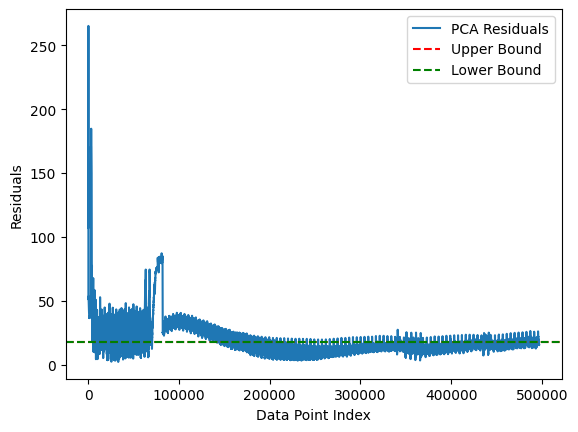

In [14]:
plot_residuals(train_residuals)

##### Residuals of test data

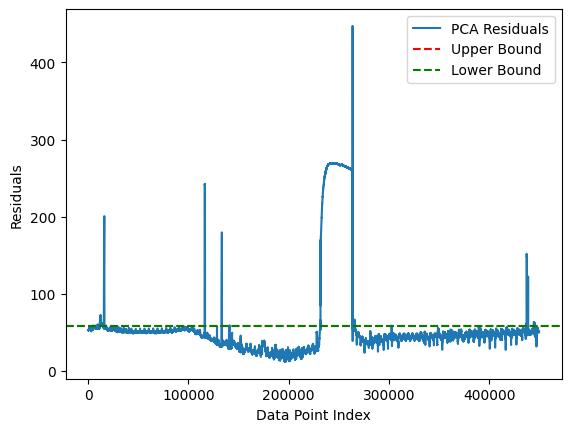

In [15]:
plot_residuals(test_residuals)

#### Explanation
##### On residuals of train data
Initially you can see an increased curve, which indicates abnormalties in inital data points, which is due to signal values highly flactuating initially which can be seen from the third graph in the start, as most of them only start exerting cyclic or patterned behaviour later on, resulting in anomalies in the start. The fact that the graph has much lower residual with low fluctuations indicates that there are less anomalies towards the end as most of the signals show patterned behaviour, which PCA is good in identifying. I think it would be better to remove them, as they  
##### On residuals of test data
Here you can see residuals being more or less equal throughout the graph, with some extremely clear indication of anomalies, which are shown by an increased curve at that point 

#### Removing anomalies
I think it is better to remove the anomalies from the training data, so that PCA doesn't focus on removing outliers and noise from data, but rather does what is is supposed to, such as finding patterns in the data. Alhtough presense of anomalies could also have it's positives, as depending on how it is used might help to predict anomalies in the future, so it is better to try both of them, but for this case I would rather remove them.
#### What can be detected?
Firstly it can help us identify noisy data in the dataset and set it as anomalies, also it will help with finding extreme values and isolated values, which are a lot different to others


### PCA for different num_component
#### 15 Compontents

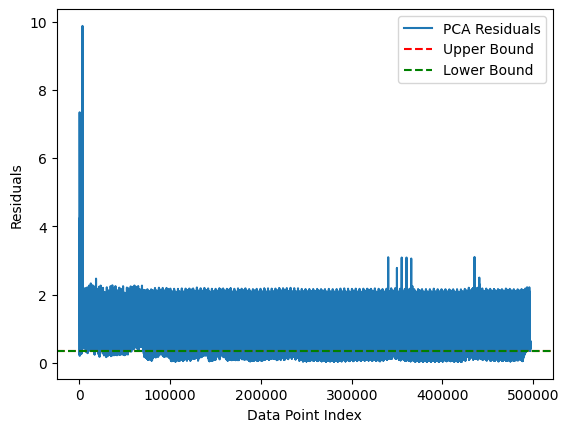

In [23]:
plot_residuals(pca_anomalies_detection(train_data_features, train_data_features, 15))

It indicates clear anomalies in the start, although after that it doesn't indicate anomalies clearly, which can be seen in the actual sensor data visualization, due to the graph being solid without an ability to properly see it's movement. We could decrease number of components.

#### 10 Components

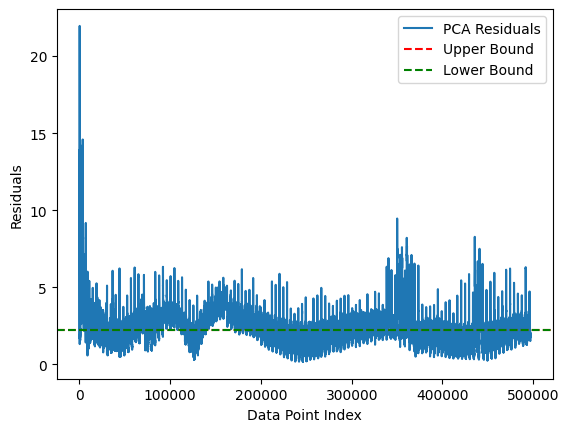

In [22]:
plot_residuals(pca_anomalies_detection(train_data_features, train_data_features, 10))

In this graph, same anomalies can be seen in the start and the movement of the graph further down the datapoints is more clear, although it would still be hard to find a good threshold, as due to high fluctitations of normal data it would result in an increased amount of false-positives, so we can try decreasing even more.

#### 5 Components

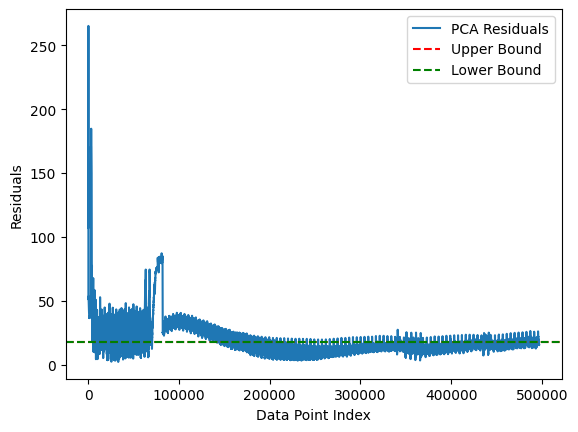

In [21]:
plot_residuals(pca_anomalies_detection(train_data_features, train_data_features, 5))

Here you can see it shows anomalies clearly and moreover explains more than 97% of the total variance. It wouldn't result in increased amount of false positives as threshold is relatively easy to find, that doesn't identify normal behaviour as anomalies. I think it would suit it great, although we can try to decrease a bit more and return here if it is worse. 

#### 2 Components

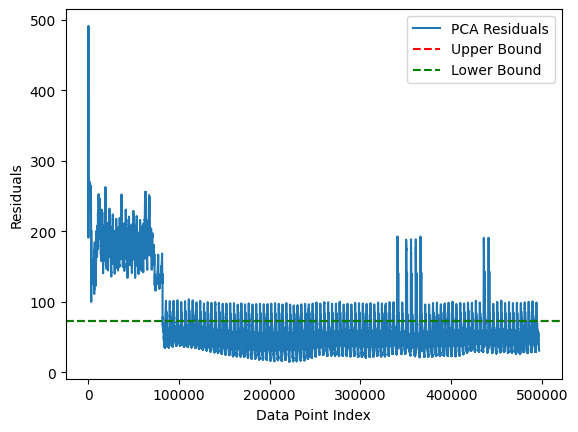

In [28]:
plot_residuals(pca_anomalies_detection(train_data_features, train_data_features, 2))

Here you can see that the graph clearly indicates portions of data where the cyclic behaviour breaks for some sensors, but it feels like there is a loss of information as it shows clear broken behaviour for some sensors, when other broken behaviour for other sensors is not indicated. Like in the start portion most of the sensors already experience normal behaviour, while the graph still shows high residual for that area. Hence it is underfitted, so I would move back to 5 number of components as the one to use, as it accounts for the behaviour of the most of the sensors.

## Kaggle Utilities (Bonus) 

In [176]:
num_components = 5
multiplier = 0.20


residuals = pca_anomalies_detection(train_data_features, test_data_features, num_components)

mean = np.mean(residuals)
std = np.std(residuals)


#residual_threshold = 1555 # Set a threshold based on observation
anomalies = [("Attack" if (residual - mean > std * multiplier) else "Normal" ) for i, residual in enumerate(residuals)]

In [177]:

anomaly_df = pd.DataFrame(anomalies, columns=['Label'])

anomaly_df['Index'] = anomaly_df.index

anomaly_df = anomaly_df[['Index', 'Label']]

anomaly_df.to_csv('anomaly.csv', index=False)

In [174]:
def print_result(anomalies):
    print(f"Results ({multiplier}, {num_components}):")
    # Count the number of attacks
    num_attacks = anomalies.count("Attack")

    # Count the number of normal
    num_normals = anomalies.count("Normal")

    print(f"Normals: {num_normals}; Attacks: {num_attacks}; Total: {num_normals + num_attacks}")
    

print_result(anomalies)

Results (0.25, 5):
Normals: 415815; Attacks: 34104; Total: 449919


 Res 1:
 Normals: 432346; Attacks: 17573; Total: 449919
 Res 2 (m=1.93, n_c=11): 
 Normals: 444171; Attacks: 5748; Total: 449919 => 0.93725
 Res 3 (0.2, 6):
 0.97471
 Normals: 442304; Attacks: 7615; Total: 449919
 Res 4 0.27, 3:
Normals: 379579; Attacks: 70340; Total: 449919
Results O.55, 12:
Normals: 402411; Attacks: 47508; Total: 449919
Results 0.08, 5 (0.97479):
Normals: 414292; Attacks: 35627; Total: 449919
Results (0.06, 4) 0.96538:
Normals: 401694; Attacks: 48225; Total: 449919
